
# Data Wrangling 


## Gather

In [1]:
#importing the first file which has the tweets' text and few other information
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('twitter-archive-enhanced.csv')

In [2]:
#importing the second file which has the tweets' images and few other information
import requests
import os
folder_name = 'image_predictions'
if not os.path.exists('image_predictions'):
    os.makedirs('image_predictions')
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open('image-predictions', mode='wb') as file:
    file.write(response.content)
df2 = pd.read_csv("image-predictions", sep = "\t")



In [3]:
#importing the third file which has retweet and favorite counts

import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
# read the file in DataFrame

df_list = []

with open('tweet-json copy', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        favorite_count = tweet['favorite_count']
        df_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': favorite_count})
        
api_df_now = pd.DataFrame(df_list)

# Assess


In [4]:
df.info()
df.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [5]:
df2.info()
df2.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [6]:
api_df_now.info()
api_df_now.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


,favorite_count,retweet_count,tweet_id
count,2354.000000,2354.000000,2.354000e+03
mean,8080.968564,3164.797366,7.426978e+17
std,11814.771334,5284.770364,6.852812e+16
min,0.000000,0.000000,6.660209e+17
25%,1415.000000,624.500000,6.783975e+17
50%,3603.500000,1473.500000,7.194596e+17
75%,10122.250000,3652.000000,7.993058e+17
max,132810.000000,79515.000000,8.924206e+17


## Clean
#### Define
##Quality:
    1. rating_numerator column: there are some ratings out of range like 204, 420, 666, 1776
    2. name column: some dogs don't have a name like "a"
    3. text column: some tweets are just general tweets, they are not about a specific dog
    4. rating_denominator column: the rating denominator should be fixed at 10, some entries are different than 10
    5. doggo, floofer, pupper, puppo classsifications: some dogs don't have this classification and marked as "none" in the four columns
    6. p1,p2,p3 columns: sometimes falsly identified the dog in the picture as another animal/object like in Id number 2054, https://pbs.twimg.com/media/CVFBzpXVEAAHIOv.jpg
    7. timestamp is an object which will make it difficult to perform numerical operations
    8. jpg_url is available for 2074 records only
    9. rating numerator column is an integer where it should be a float
    10. timestamp has an addition +0000 at the end, which will create problems if we want to perform numerical operations on date column
     11. some column labels are unclear such as "p1", "p1_conf"......etc

##Tidiness:
    1. the dog type variable should be only one column instead of 4, with each record has its type in the cell, i.e doggo, floofer, pupper, puppo or none
    2. Each observational unit "tweet" has it is complete data divided between three different tables/files. separate file for tweet and its text, another file has the retweet/favorite count and the third file has the image and image predictions info
     

#### code

#tidiness issue: 
2. Each observational unit "tweet" has it is complete data divided between three different tables/files. separate file for tweet and its text, another file has the retweet/favorite count and the third file has the image and image predictions info

In [7]:
df_2sets = pd.merge(df, api_df_now, on ='tweet_id', how= 'outer' )
df_master = pd.merge(df_2sets, df2, on ='tweet_id', how= 'outer' )
df_master.to_csv('df_master.csv')


In [8]:
#Test
#making sure all the data is merged by diplaying data info
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
favorite_count                23

In [9]:
# 2. remove the +0000 at the end of the timestamp column through slicing
df_master_clean = df_master.copy()
df_master_clean['timestamp'] = df_master_clean['timestamp'].str.replace('\+0000','')


In [10]:
#test
#Diplaying part of data to make sure that the +0000 issue is fixed
df_master_clean.head()


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


#tidiness issue
1. the dog type variable should be only one column instead of 4, with each record has its type in the cell, i.e doggo, floofer, pupper, puppo or none

In [11]:

df_master_clean.iloc[:, 13:17  ] = df_master_clean.iloc[:, 13:17 ].replace('None','')
df_master_clean['dog_stage'] = df_master_clean['doggo'] + df_master_clean['floofer'] + df_master_clean['pupper'] + df_master_clean['puppo']

In [12]:
#test
#displaying the data to make sure the new column in created
df_master_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,


#quality issue
1. rating_numerator column: there are some ratings out of range like 204, 420, 666, 1776: after doing some of the above cleaning, three out of range values existed due to extractino error, so I decided to delete them since they are only three.

In [13]:
df_master_clean = df_master_clean[(df_master_clean.rating_numerator < 20)]


In [14]:
#test
#diplaying value counts of the rating numerator column to make sure the values are fixed to below 20
df_master_clean['rating_numerator'].value_counts()

12    558
11    464
10    461
13    351
9     158
8     102
7      55
14     54
5      37
6      32
3      19
4      17
1       9
2       9
0       2
15      2
17      1
Name: rating_numerator, dtype: int64

#quality issue
2. name column: some dogs don't have a name like "a", the a values got replaced by nan values if the tweet has no dog name


In [15]:
import re
pattern_2 = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
for index, row in df_master_clean.iterrows():  
    try:
        if row['name'] == "a":
            c_name = re.findall(pattern_2, row['text'])[0]
            df_master_clean.loc[index,'name'] = df_master_clean.loc[index,'name'].replace('a', c_name)
        elif row['name'] == 'an':
            c_name = re.findall(pattern_2, row['text'])[0]
            df_master_clean.loc[index,'name'] = df_master_clean.loc[index,'name'].replace('an', c_name)
    except IndexError:
        df_master_clean.loc[index,'name'] = np.nan

            


In [16]:
#test
#displaying the value counts of the "name" column to make sure false names are dropped
df_master_clean.name.value_counts(dropna = False)

None         728
NaN           40
Charlie       12
Cooper        11
Lucy          11
Oliver        11
Lola          10
Tucker        10
Penny         10
Bo             9
Winston        9
the            8
Sadie          8
Bailey         7
Buddy          7
Toby           7
Daisy          7
Bella          6
Leo            6
Scout          6
Jax            6
Stanley        6
Koda           6
Milo           6
Rusty          6
Dave           6
Oscar          6
Jack           6
very           5
Sammy          5
            ... 
Jennifur       1
Enchilada      1
Chase          1
Kaia           1
Scruffers      1
Dylan          1
Corey          1
Rambo          1
Koko           1
Lenox          1
Ester          1
Finnegus       1
Diogi          1
Monty          1
Suki           1
DonDon         1
Skittle        1
Alf            1
Grey           1
Amy            1
Eleanor        1
Lolo           1
Zooey          1
Loomis         1
Glacier        1
Geoff          1
Tanner         1
Bertson       

quality issue
4. rating_denominator column: the rating denominator should be fixed at 10, some entries are different than 10


In [17]:

df_master_clean = df_master_clean[(df_master_clean.rating_denominator == 10)]

In [18]:
#test
#diplaying value counts of the rating denominator column to make sure the values are fixed to below 20
df_master_clean['rating_denominator'].value_counts()

10    2324
Name: rating_denominator, dtype: int64

quality issue
5. doggo, floofer, pupper, puppo classsifications: some dogs don't have this classification and marked as "none" in the four columns
after we replaced the "none" wiht empty cells, we assign empty cells as "NaN" to perform proper calculation

In [19]:

df_master_clean['dog_stage'] = df_master_clean['dog_stage'].str.replace(' ','NaN')

In [20]:
#test
#diplaying value counts of the dog stage column to make sure the empty values are replaced with "Nan"
df_master_clean['dog_stage'].value_counts()

                1945
pupper           244
doggo             83
puppo             29
doggopupper       12
floofer            9
doggopuppo         1
doggofloofer       1
Name: dog_stage, dtype: int64

6.p1,p2,p3 columns: sometimes falsly identified the dog in the picture as another animal/object like in Id number 2054, https://pbs.twimg.com/media/CVFBzpXVEAAHIOv.jpg
removing records where the image is not for a dog for clearer insights

In [21]:
df_master_clean = df_master_clean[(df_master_clean.p1_dog == True)]

In [22]:
#test
#displaying the value counts of column (p1_dog) to make sure the records which don't have a dog picture are eliminated 
df_master_clean['p1_dog'].value_counts()

True    1514
Name: p1_dog, dtype: int64

quality issue
7. timestamp is an object which will make it difficult to perform numerical operations
convert the timestamp column to time through datetime function

In [23]:

df_master_clean['timestamp'] = pd.to_datetime(df_master_clean['timestamp'])
     # extract month and day of week from Start Time to create new columns
df_master_clean['hour'] = df_master_clean['timestamp'].dt.hour
df_master_clean['month'] = df_master_clean['timestamp'].dt.month
df_master_clean['day_of_week'] = df_master_clean['timestamp'].dt.weekday_name
df_master_clean['year'] = df_master_clean['timestamp'].dt.year

In [24]:
#test
#displaying the data frame to make sure the month, day, hour columns are created at the end
df_master_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,hour,month,day_of_week,year
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.090647,True,papillon,0.068957,True,,0,8,Tuesday,2017
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,0.078253,True,kelpie,0.031379,True,,0,7,Monday,2017
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,0.225770,True,German_short-haired_pointer,0.175219,True,,16,7,Saturday,2017
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,...,0.116317,True,Indian_elephant,0.076902,False,,0,7,Saturday,2017
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",...,0.199287,True,ice_lolly,0.193548,False,,16,7,Friday,2017


In [25]:
df_master_clean['name'].replace('None', np.nan, inplace=True)

Quality issue
8. jpg_url is available for 2074 records only, so removing the records that have no images


In [26]:
tweets_with_image = list(df2.tweet_id.unique())

len(tweets_with_image) == df.tweet_id.isin(tweets_with_image).sum()
df = df[df.tweet_id.isin(tweets_with_image)]

In [27]:
#test
#displaying value counts to see if the records above are deleted
#keeping only the dogs's column with "True" value, already took care of that problem
df_master_clean['p1_dog'].value_counts()

True    1514
Name: p1_dog, dtype: int64

getting records that include data in the retweet_status_id. and removing them

In [28]:
df_master_clean = df_master_clean[df_master_clean.retweeted_status_id.isnull()]
df_master_clean = df_master_clean[df_master_clean.retweeted_status_user_id.isnull()]
df_master_clean = df_master_clean[df_master_clean.retweeted_status_timestamp.isnull()]

In [29]:
#test
#displaying the contents of the "user retweet status" column to make sure it has no data
df_master_clean['retweeted_status_user_id'].value_counts()

Series([], Name: retweeted_status_user_id, dtype: int64)

some column labels are unclear such as "p1", "p1_conf"......etc


In [30]:
df_master_clean.rename(columns={'p1': 'dog_prediction_1', 'p1_conf': 'confidence_level 1', 'p1_dog': 'Dog_or_other_object1','p2': 'dog_prediction_2', 'p2_conf': 'confidence_level 2', 'p2_dog': 'Dog_or_other_object2','p3': 'dog_prediction_3', 'p3_conf': 'confidence_level 3', 'p3_dog': 'Dog_or_other_object3'}, inplace=True)

In [31]:
#test
#making sure the columns are renamed
df_master_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,confidence_level 2,Dog_or_other_object2,dog_prediction_3,confidence_level 3,Dog_or_other_object3,dog_stage,hour,month,day_of_week,year
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.090647,True,papillon,0.068957,True,,0,8,Tuesday,2017
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,0.078253,True,kelpie,0.031379,True,,0,7,Monday,2017
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,0.225770,True,German_short-haired_pointer,0.175219,True,,16,7,Saturday,2017
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,...,0.116317,True,Indian_elephant,0.076902,False,,0,7,Saturday,2017
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",...,0.199287,True,ice_lolly,0.193548,False,,16,7,Friday,2017


quality issue
9. rating numerator column is an integer where it should be a float

In [32]:

df_master_clean['rating_numerator']= df_master_clean['rating_numerator'].astype(float)


In [ ]:
#test
#displaying the data frame infor to make sure the rating numerator column was converted to floar
df_master_clean.info()

In [33]:
df_master_clean.loc[df_master_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
df_master_clean.loc[df_master_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
df_master_clean.loc[df_master_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'


In [34]:
#test
# displaying the value counts of the dog_stage column to make sure the combined names issue is fixed
df_master_clean['dog_stage'].value_counts()

creating a CSV file of the clean data frame

In [35]:
df_master_clean.to_csv('df_master_clean.csv')

visualisation

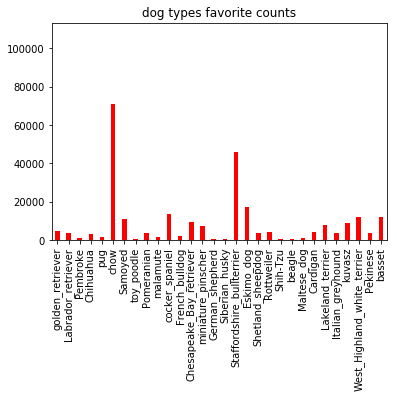

In [36]:
name_favorite_plot = df_master_clean.groupby(["name"])["favorite_count"].mean()
index = np.arange(len(name_favorite_plot))
width = 0.4
red_bars = plt.bar(index,name_favorite_plot, width, color='r', alpha = 1, label = 'name_favorite_plot')
plt.title('dog types favorite counts')
df_master_clean.dog_prediction_1.value_counts().head(30).plot(kind = 'bar')
labels = name_favorite_plot.index;



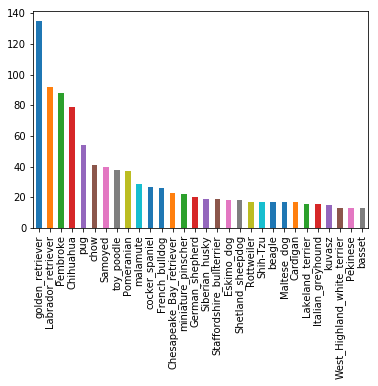

In [37]:
df_master_clean.dog_prediction_1.value_counts().head(30).plot(kind='bar')


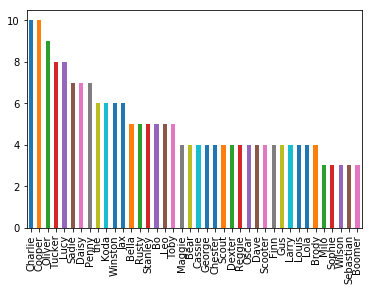

In [38]:
df_master_clean.name.value_counts().head(40).plot(kind='bar')

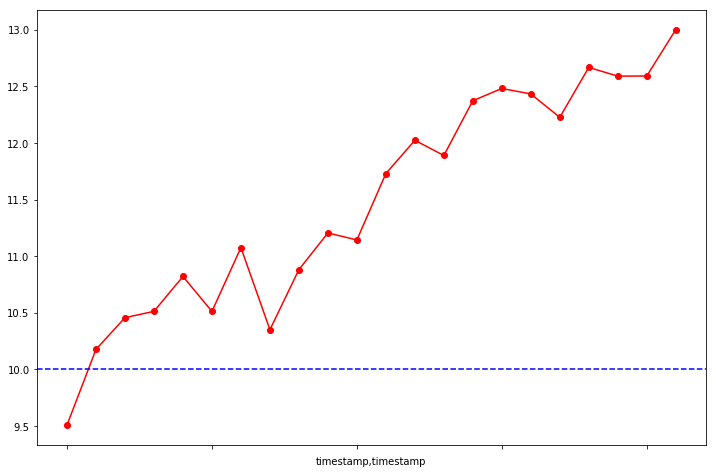

In [39]:
df_t = df_master_clean.copy()
df_t.index = df_t['timestamp'] 
df_t.drop('timestamp', axis=1)
df_t.sort_index()
data_to_plot = df_t.groupby([(df_t.index.year),(df_t.index.month)]).rating_numerator.mean()
data_to_plot.plot(style='-ro', figsize=(12,8),label='Total average rating')

plt.axhline(y=10.0, color='b', linestyle='--', label='Out of rating')


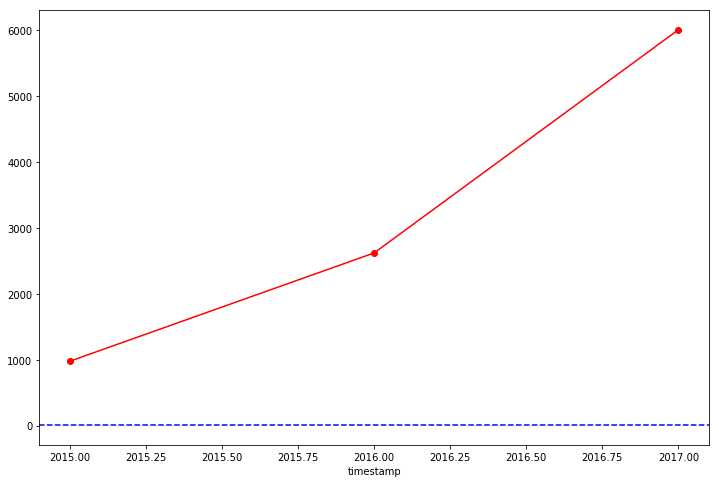

In [40]:
df_t2 = df_master_clean.copy()
df_t2.index = df_t2['timestamp'] 
df_t2.drop('timestamp', axis=1)
df_t2.sort_index()
data_to_plot = df_t2.groupby([(df_t2.index.year)]).retweet_count.mean()
data_to_plot.plot(style='-ro', figsize=(12,8),label='Total average rating')

plt.axhline(y=10.0, color='b', linestyle='--', label='Out of rating')


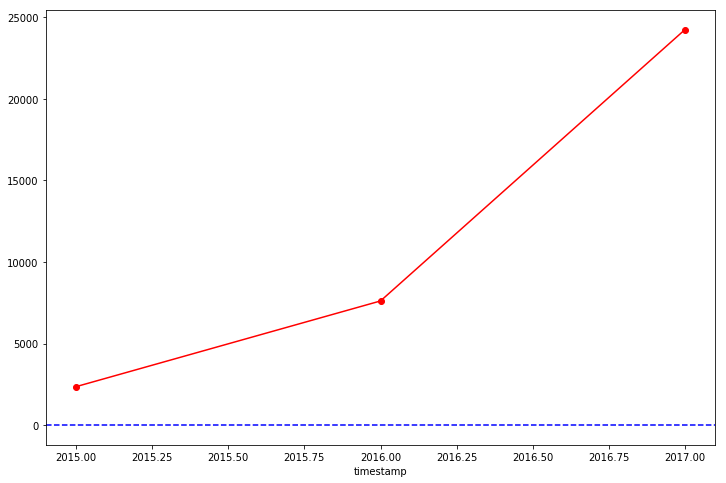

In [41]:
df_t2 = df_master_clean.copy()
df_t2.index = df_t2['timestamp'] 
df_t2.drop('timestamp', axis=1)
df_t2.sort_index()
data_to_plot = df_t2.groupby([(df_t2.index.year)]).favorite_count.mean()
data_to_plot.plot(style='-ro', figsize=(12,8),label='Total average rating')

plt.axhline(y=10.0, color='b', linestyle='--', label='Out of rating')

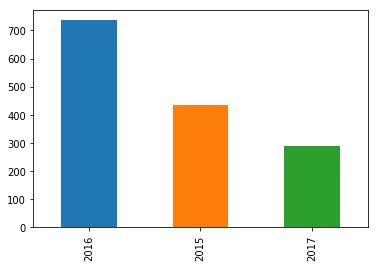

In [42]:
df_master_clean.year.value_counts().plot(kind='bar')
